## Table of contents
1. [Importing libraries ](#Importing_Libraries)
2. [Importing the Data](#Importing_the_Data)
3. [Data Exploration](#Data_Exploration)
4. [Data Preparation](#Data_Preparation)
5. [Data Modeling](#Data_Modeling)
6. [Model Evaluation](#Model_Evaluation)

<a id='Importing_Libraries'></a>

## Importing Libraries

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import dataframe_image as dfi

%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Saving the figures
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "AirBnB-London-2020"
IMAGES_PATH = "../reports/figures/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

<a id='Importing_the_Data'></a>

### Importing the Data

In [3]:
df_listings = pd.read_csv('../data/raw/listings.csv', dtype={'price': 'object',
                                                      'weekly_price': 'object',
                                                      'monthly_price': 'object',
                                                      'security_deposit': 'object',
                                                      'cleaning_fee': 'object',
                                                      'extra_people': 'object',
                                                      'license': 'object', 
                                                      'jurisdiction_names': 'object',})

In [4]:
df_listings.shape

(77136, 74)

In [5]:
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",$105.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,75%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",$40.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",$75.00,10,50,10.0,10.0,50.0,50.0,10.0,50.0,

<a id='Data_Exploration'></a>

## Data Exploration

In [6]:
# General statistics of the data
df_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.713600e+04,7.713600e+04,7.713600e+04,77095.000000,77095.000000,0.0,77136.000000,77136.000000,77136.000000,0.0,72284.000000,75992.000000,77136.000000,7.713600e+04,77135.000000,77135.000000,7.713500e+04,7.713500e+04,77135.000000,7.713500e+04,0.0,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,52965.000000,52902.000000,52911.000000,52855.000000,52904.000000,52856.000000,52855.000000,77136.000000,77136.000000,77136.000000,77136.000000,54705.000000
mean,2.598945e+07,2.020122e+13,9.675921e+07,24.170374,24.170374,NaN,51.510106,-0.128107,3.070006,NaN,1.488587,1.707811,5.180564,2.069624e+04,5.452855,6.908913,1.878365e+05,7.724969e+05,5.979946,7.222697e+05,NaN,11.320590,24.534757,38.320356,122.106046,15.283823,1.583891,0.045439,93.044652,9.525746,9.284270,9.649134,9.669231,9.557212,9.300974,20.686631,17.525993,2.618259,0.036559,0.607957
std,1.340272e+07,2.074232e+01,1.018449e+08,125.710654,125.710654,NaN,0.047450,0.094877,1.951961,NaN,0.884982,1.284529,22.401630,4.066635e+06,23.192706,30.399336,1.937087e+07,4.037594e+07,25.947365,3.774108e+07,NaN,13.215171,26.900944,40.683909,144.228420,35.440263,4.581973,0.319414,10.531457,1.033406,1.186098,0.931390,0.929136,0.869663,1.077889,98.922987,96.070725,16.523581,0.509314,0.865626
min,1.155100e+04,2.020122e+13,2.010000e+03,0.000000,0.000000,NaN,51.292570,-0.496870,0.000000,NaN,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.526581e+07,2.020122e+13,1.627615e+07,1.000000,1.000000,NaN,51.484497,-0.188510,2.000000,NaN,1.000000,1.000000,1.000000,3.100000e+01,1.000000,1.000000,9.000000e+01,9.000000e+01,1.000000,9.000000e+01,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.110000
50%,2.623901e+07,2.020122e+13,4.997764e+07,1.000000,1.000000,NaN,51.514230,-0.126040,2.000000,NaN,1.000000,1.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,NaN,0.000000,3.000000,13.000000,57.000000,3.000000,0.000000,0.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,0.320000
75%,3.816095e+07,2.020122e+13,1.558912e+08,3.000000,3.000000,NaN,51.539340,-0.069387,4.000000,NaN,2.000000,2.000000,3.000000,1.125000e+03,4.000000,4.000000,1.125000e+03,1.125000e+03,4.000000,1.125000e+03,NaN,28.000000,58.000000,88.000000,262.000000,14.000000,1.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,2.000000,1.000000,0.000000,0.780000
max,4.707231e+07,2.020122e+13,3.803358e+08,3450.000000,3450.000000,NaN,51.679980,0.288570,16.000000,NaN,50.000000,50.000000,1125.000000,1.000000e+09,1125.000000,1125.000000,2.147484e+09,2.147484e+09,1125.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,817.000000,479.000000,22.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000

In [7]:
# Dataframe columns information
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77136 entries, 0 to 77135
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            77136 non-null  int64  
 1   listing_url                                   77136 non-null  object 
 2   scrape_id                                     77136 non-null  int64  
 3   last_scraped                                  77136 non-null  object 
 4   name                                          77112 non-null  object 
 5   description                                   74048 non-null  object 
 6   neighborhood_overview                         47437 non-null  object 
 7   picture_url                                   77136 non-null  object 
 8   host_id                                       77136 non-null  int64  
 9   host_url                                      77136 non-null 

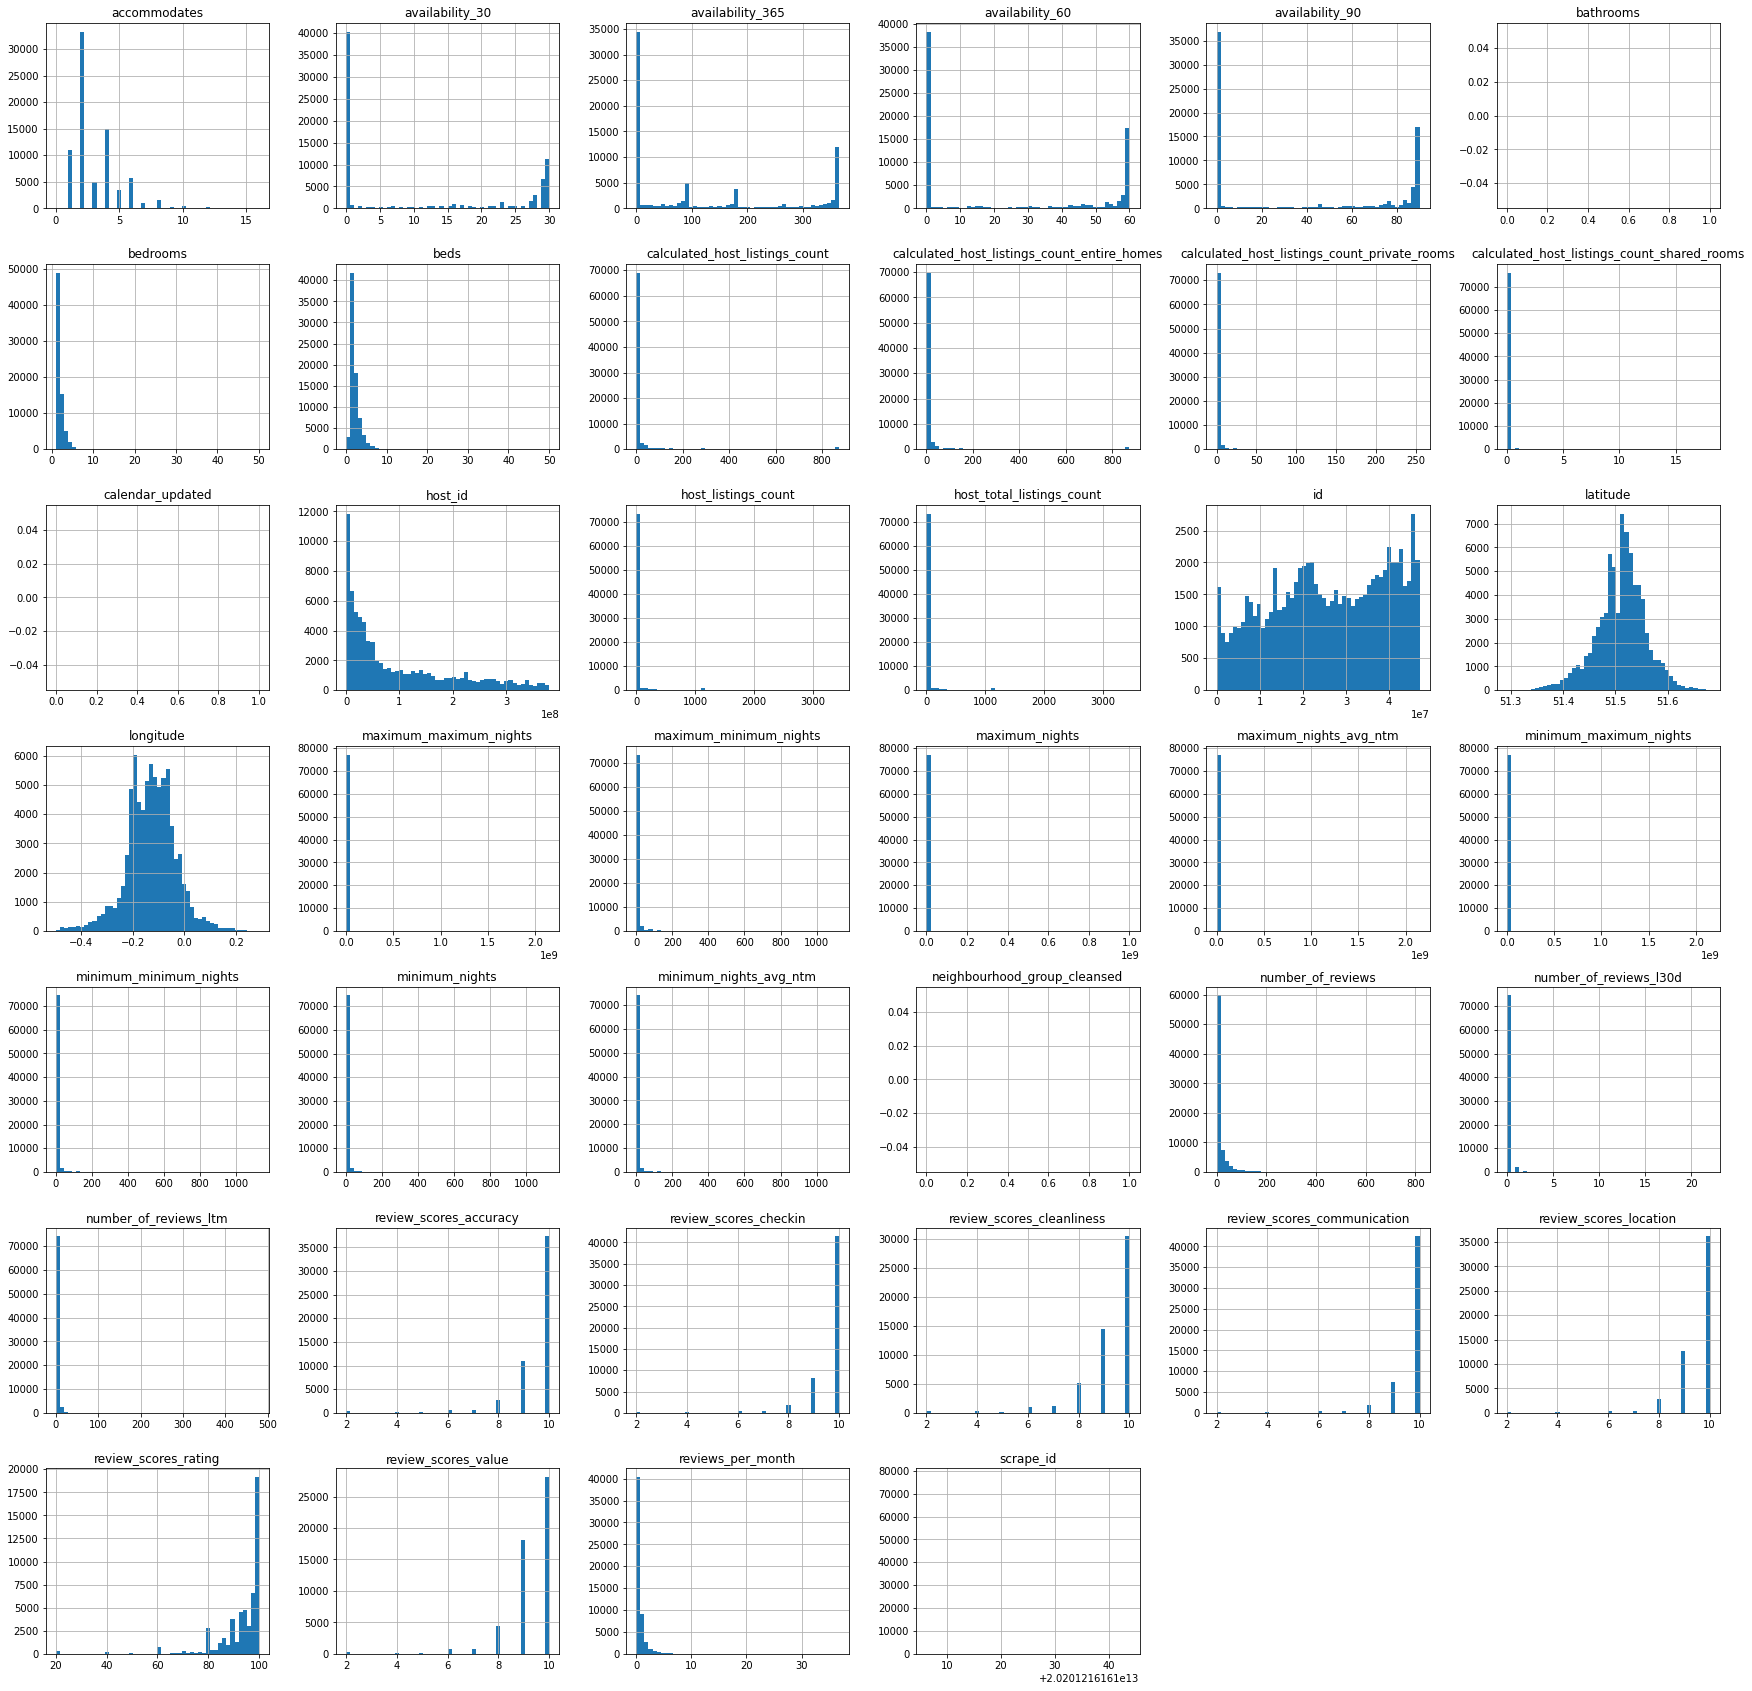

In [8]:
# Checking the distribution of all variables
df_listings.hist(bins=50, figsize=(30,30))
plt.show()

In [9]:
# Finding the columns with more than 75% of values missing
set(df_listings.columns[df_listings.isnull().mean()>0.75])

{'bathrooms', 'calendar_updated', 'license', 'neighbourhood_group_cleansed'}

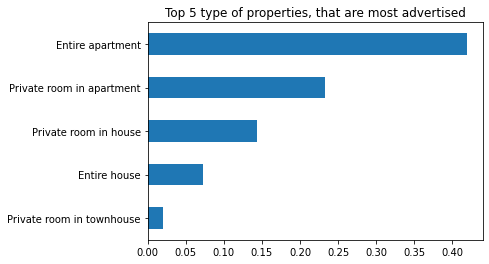

In [10]:
# Exploring the data for number of property types
neighbourhood_vals = df_listings['property_type'].value_counts()

((neighbourhood_vals[0:5]/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("Top 5 type of properties, that are most advertised");

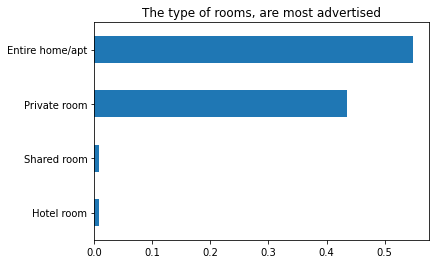

In [11]:
# Exploring the data for number of room types
room_vals = df_listings['room_type'].value_counts()

((room_vals/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("The type of rooms, are most advertised");

In [12]:
# Exploring the data unique bathrooms
df_listings['bathrooms_text'].value_counts()

1 bath               32520
1 shared bath        14028
2 baths               9175
1 private bath        6014
1.5 baths             5077
1.5 shared baths      3637
2.5 baths             1909
2 shared baths        1367
3 baths               1154
3.5 baths              460
2.5 shared baths       346
4 baths                230
3 shared baths         167
0 shared baths         164
0 baths                154
Half-bath              107
Shared half-bath       105
4.5 baths               91
5 baths                 46
3.5 shared baths        36
Private half-bath       22
6 baths                 21
4 shared baths          20
5.5 baths               20
6 shared baths          19
10 baths                18
4.5 shared baths         8
6.5 baths                8
5 shared baths           7
7 baths                  5
8 baths                  4
8 shared baths           3
7 shared baths           2
7.5 baths                2
8.5 baths                2
9 baths                  1
35 baths                 1
1

<a id='Data_Preparation'></a>

## Data Preparation

In [13]:
# Applying a new format to the numerical columns so that they can be explored
class format_data:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self
    
    def text_to_int(self):
        self = self.str.split(' ').str[0].replace('Half-bath', '0.5', regex=True).replace('Shared', '0.5', regex=True) \
                                         .replace('Private', '1', regex=True).astype('float')
              
        return self

In [14]:
# Applying format to the price column
float_list = ['price']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [15]:
# Applying format to the host_response_rate and host_acceptance_rate column
percentage_list = ['host_response_rate','host_acceptance_rate']
for x in percentage_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

In [16]:
# Applying format to the bathrooms_text column
text_list = ['bathrooms_text']
for x in text_list:
    df_listings[x] = format_data.text_to_int(df_listings[x])

In [17]:
# Exploring the data unique bathrooms
df_listings['bathrooms_text'].value_counts()

1.0     52584
2.0     10542
1.5      8714
2.5      2255
3.0      1321
3.5       496
0.0       318
4.0       250
0.5       212
4.5        99
5.0        53
6.0        40
5.5        20
10.0       18
6.5         8
8.0         7
7.0         7
9.0         2
8.5         2
7.5         2
35.0        1
11.0        1
17.0        1
11.5        1
10.5        1
12.0        1
Name: bathrooms_text, dtype: int64

### Removing Price Outliers

In [18]:
def find_outliers(df_listings):
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings["price"], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings["price"],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings["price"] >= Q1 - step) & 
                                  (df_listings["price"] <= Q3 + step))].sort_values(by=["price"])
                                  
    #filtered_data["price"].hist()
    #outliers = filtered_data[filtered_data["price"] >= 1000.00]
    
    return filtered_data
                                  
                                  
outliers = find_outliers(df_listings).index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

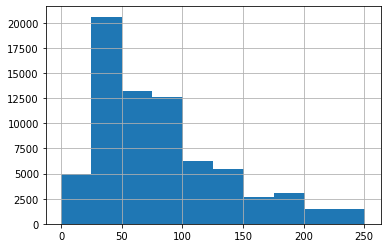

In [19]:
# Checking the new distribution of prices
df_listings["price"].hist()

## Business Questions

- What is the spread of prices using the map of London map? Prices by all year availability?

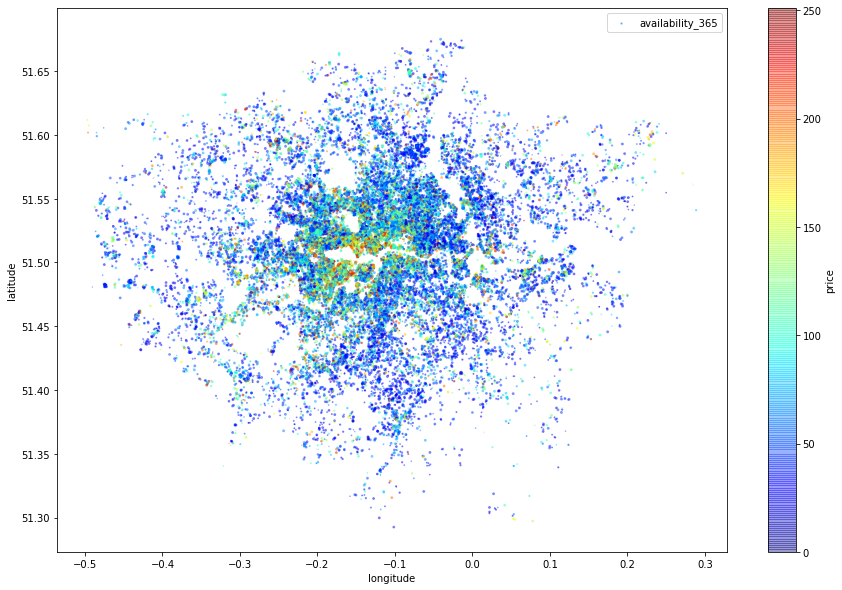

In [20]:
# Initial map of London prices by all year availability
df_listings.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,10),
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c="price", cmap=plt.get_cmap('jet'), 
                 colorbar=True,
                 sharex=False)
plt.show()

Saving figure availability_365_prices_scatterplot


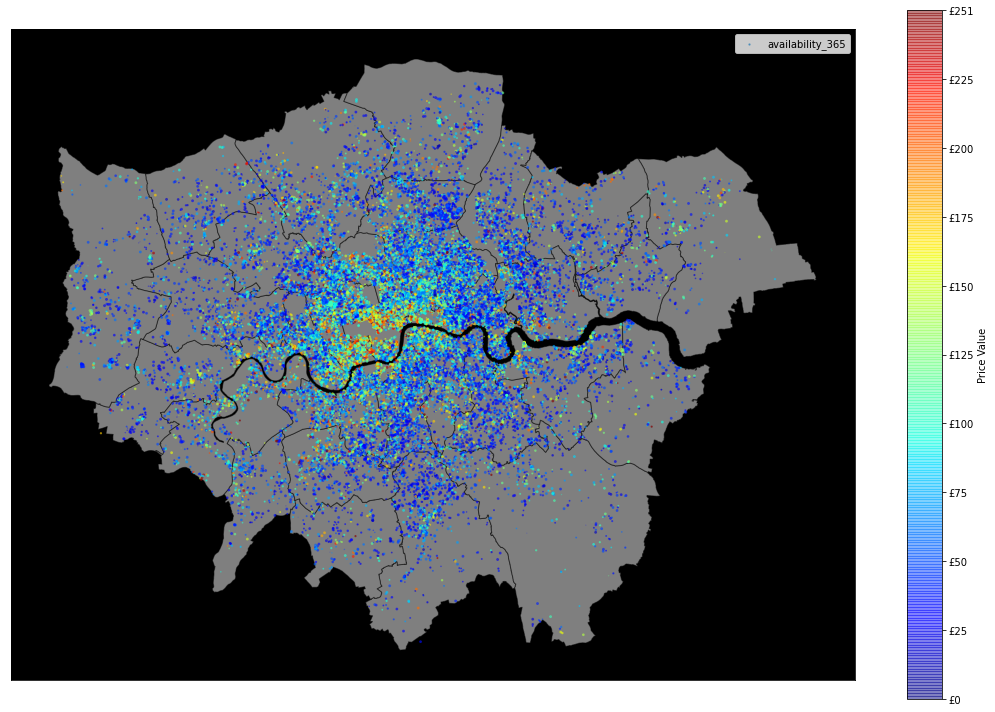

In [21]:
# Completed map of London prices by all year availability
fig, ax = plt.subplots(1, 1, figsize=(15,10))

basemap = gpd.read_file('../data/external/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
basemap = basemap.to_crs(epsg=4326)


basemap = basemap.plot(alpha=0.5, edgecolor='k',color='White',figsize=(15,10),ax=ax)
basemap.set_facecolor('black')


x, y = df_listings['longitude'].values, df_listings['latitude'].values
basemap.scatter(x,y, alpha=0.5,
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c=df_listings["price"], cmap=plt.get_cmap('jet'))


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'))
prices = df_listings["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = fig.colorbar(sm, ticks=tick_values/prices.max(), alpha=0.5)
cbar.ax.set_yticklabels(["£%d"% v for v in tick_values], fontsize=10)
cbar.set_label('Price Value', fontsize=10)

# Removing ticks
plt.xticks([]),
plt.yticks([])

plt.legend(fontsize=10)
save_fig("availability_365_prices_scatterplot")
plt.show()

- What is the average price of the listings, for the different location within London?

In [22]:
price_df = df_listings[df_listings['price'].isnull() == False]

In [23]:
price_df['neighbourhood_cleansed'].value_counts()[:5]

Westminster               7218
Tower Hamlets             6659
Hackney                   5592
Camden                    4836
Kensington and Chelsea    4359
Name: neighbourhood_cleansed, dtype: int64

In [24]:
nb_price_avg = price_df.groupby('neighbourhood_cleansed', as_index=False).mean()
nb_price_avg = pd.DataFrame(nb_price_avg).sort_values(by='price', ascending=False)

In [25]:
nb_price_avg = nb_price_avg.rename(columns={'neighbourhood_cleansed':'Neighbourhood','price': 'Avg Price'})

In [26]:
def chart_plot(data, x_label, y_label):
    
    plt.figure(figsize=(10,5))

    sns.set(style="whitegrid")
    chart = sns.barplot(x=x_label, y=y_label, data=data)

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=60, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium', 
        rotation_mode='anchor'
    )

Saving figure Neighbourhood_av_price_histogram_plots


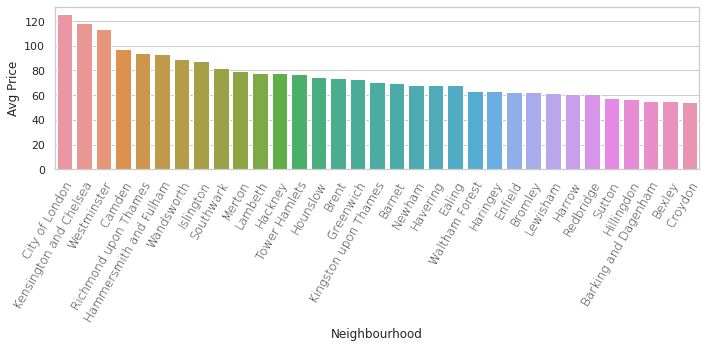

In [27]:
chart_plot(nb_price_avg,"Neighbourhood", "Avg Price")
save_fig("Neighbourhood_av_price_histogram_plots")

- What types of verifications are hosts using? How long did it take them to respond?

In [28]:
verifications_df = df_listings[df_listings['host_verifications'].isnull() == False]

In [29]:
verifications_df = verifications_df[verifications_df['host_verifications'] != '[]']

In [30]:
def verifications_types(column):
    verifications_dict = {}
    temp = []

    for i in column:
        temp.append(eval(i))
    
    for i in temp:
        try:
            for j in i:
                if j not in verifications_dict:
                    verifications_dict[j] = 1
                else:
                    verifications_dict[j] += 1
        except:
            continue
            
    return verifications_dict
        
verifications_types = verifications_types(verifications_df['host_verifications'])

In [31]:
for k,v in verifications_types.items():
    verifications_types[k] = round(v / verifications_df.shape[0] * 100, 3)

In [32]:
verifications_types = pd.DataFrame.from_dict(verifications_types,orient='index',columns=['A']).reset_index()
verifications_types = verifications_types.rename(columns={'index':'Verification Type','A': '% of listings'})
top10_verifications_types = verifications_types.sort_values(by='% of listings', ascending=False)[:10]

Saving figure Verification_type_price_histogram_plots


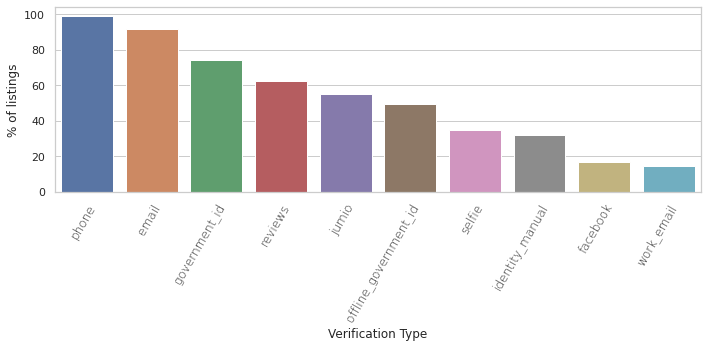

In [33]:
chart_plot(top10_verifications_types,"Verification Type", "% of listings")
save_fig("Verification_type_price_histogram_plots")

- What amenities are most used and does the amenity affect the review? 

In [34]:
df_left = df_listings[['id','amenities']]

In [35]:
df_right = df_listings[['id','review_scores_value']]

In [36]:
from ast import literal_eval

df_left['amenities'] = df_left['amenities'].apply(literal_eval)
df_left = df_left.explode('amenities')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
df_left.head()

,id,amenities
0,11551,Refrigerator
0,11551,Kitchen
0,11551,Crib
0,11551,Dedicated workspace
0,11551,Lockbox


In [38]:
result = pd.merge(df_left, df_right, on='id')

In [39]:
result = result.groupby('amenities').agg({'review_scores_value': ['count', 'min', 'max', 'mean']})

In [40]:
result = result.reset_index()

In [41]:
result.head().columns

MultiIndex([(          'amenities',      ''),
            ('review_scores_value', 'count'),
            ('review_scores_value',   'min'),
            ('review_scores_value',   'max'),
            ('review_scores_value',  'mean')],
           )

In [42]:
result = result.sort_values(by=[('review_scores_value', 'mean'),
                                ('review_scores_value',  'min'),
                                ('review_scores_value',  'max')], ascending=False)

In [43]:
result.columns = ["_".join(x) for x in result.columns.ravel()]

In [44]:
result.head().columns

Index(['amenities_', 'review_scores_value_count', 'review_scores_value_min',
       'review_scores_value_max', 'review_scores_value_mean'],
      dtype='object')

In [45]:
result.rename(columns={"amenities_":"Amenities", 
                       "review_scores_value_count":"Count Listings",
                       "review_scores_value_min":"Review Min Value",
                       "review_scores_value_max":"Review Max Value",
                       "review_scores_value_mean":"Review Avg Value"}, inplace=True)

In [46]:
result.head()

,Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
2,"14"" TV with Netflix, standard cable",1,10.0,10.0,10.0
4,"19"" HDTV with Netflix, premium cable, Roku",1,10.0,10.0,10.0
5,"20"" HDTV with standard cable",1,10.0,10.0,10.0
9,"28"" HDTV with Netflix, standard cable",1,10.0,10.0,10.0
10,"30"" TV",2,10.0,10.0,10.0


In [47]:
result = result[result['Count Listings'] > 10]

In [48]:
result = result.head(20).style.background_gradient() \
               .format({"Amenities": lambda x:x.lower()}) \
               .format({"Review Min Value": "{:20,.2f}"}) \
               .format({"Review Max Value": "{:20,.2f}"}) \
               .format({"Review Avg Value": "{:20,.2f}"}) \
               .hide_index()\
               .background_gradient(cmap='Blues')

In [49]:
result.set_properties(subset=["Amenities", 
                              "Count Listings", 
                              "Review Min Value", 
                              "Review Max Value", 
                              "Review Avg Value"], **{'text-align': 'left'}) \
      .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
stainless steel gas stove,21,8.00,10.00,9.81
cleaning products,29,9.00,10.00,9.79
pets allowed,28,9.00,10.00,9.75
clothing storage,11,9.00,10.00,9.73
record player,46,6.00,10.00,9.72
self check-in,158,8.00,10.00,9.71
electric stove,52,8.00,10.00,9.69
bathroom essentials,279,8.00,10.00,9.68
bedroom comforts,279,8.00,10.00,9.68
full kitchen,210,8.00,10.00,9.66


In [50]:
# dfi.export(result, '../reports/figures/top_amenities.png')

<a id='Data_Modeling'></a>

## Data Modeling

### What features assist in the pricing of a listing? 
- Could the price be predicted?
- importance of the features, rank features

### Preparing data

#### Removing rows with no target value

In [51]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,1.0,0.90,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1.0,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",105.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,1.0,0.75,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1.0,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",40.0,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,1.00,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1.0,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",75.0,10,50,10.0,10.0,50.0,50.0,10.0,50.0,NaN,t,29,59,62,189,202

In [52]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df = df_listings[df_listings['price'] != 0]

In [53]:
df = df[df['bathrooms_text'].notna()]

In [54]:
# Renaming property types to other where their total count is less than 30
counts = df['property_type'].value_counts()

df['property_type'] = np.where(df['property_type'].isin(counts.index[counts >= 30]), df['property_type'], 'Other')

#### Creating new features

In [55]:
# Creating the 'amenities - count' column
df.loc[:,"amenities_count"] = [len(i) for i in df["amenities"]]

#### Removing Features

In [56]:
def drop_columns(df):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','scraped','first_review','last_review','cancellation_policy', 'maximum', 
                  'minimum', 'host','requires']
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['name','id','description','neighborhood_overview','latitude',
                          'longitude','neighbourhood','amenities','calendar_updated'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

df = drop_columns(df)

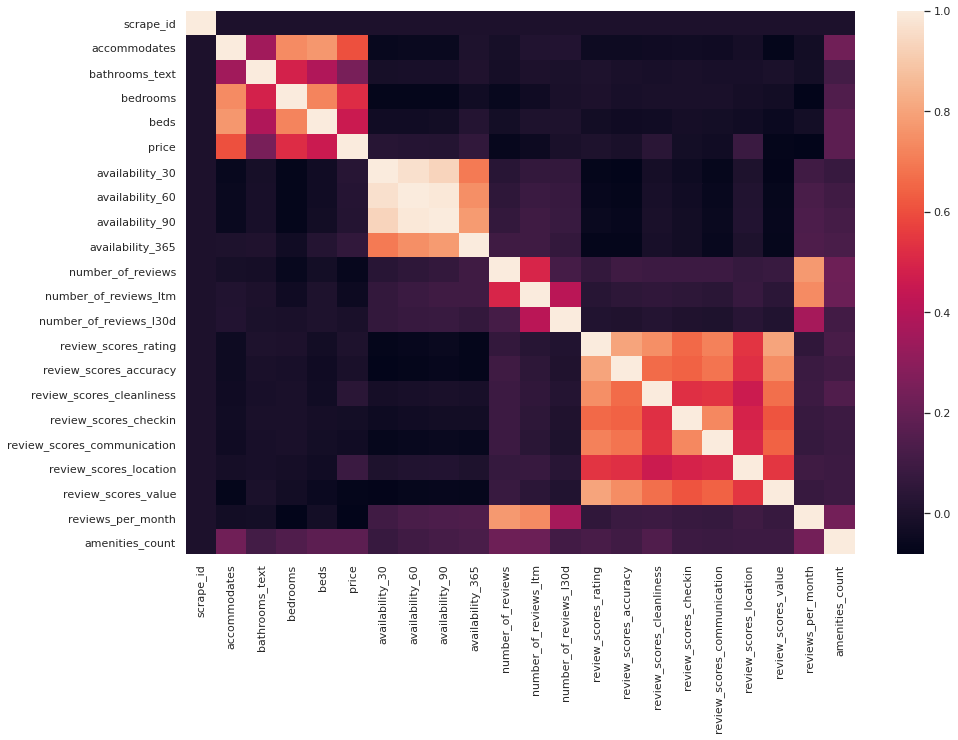

In [57]:
# calculate the correlation matrix
corr = df.corr()

plt.figure(figsize = (15,10))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [58]:
df_object = df.select_dtypes(include=['object'])

In [59]:
df_object.columns

Index(['neighbourhood_cleansed', 'property_type', 'room_type',
       'has_availability', 'instant_bookable'],
      dtype='object')

In [60]:
new_df = df[['neighbourhood_cleansed','property_type', 'room_type', 'bathrooms_text', 
             'has_availability','instant_bookable', 'amenities_count', 'accommodates', 'bedrooms', 
             'beds', 'price']]

#### Train / Test split

In [61]:
# Extract features and labels
X = new_df.drop("price", axis=1) # drop labels for training set
y = new_df["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [63]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50152, 10)
(21495, 10)
(50152,)
(21495,)


In [64]:
X_train_num = X_train.select_dtypes(include=['float', 'int'])
X_train_cat = X_train.select_dtypes(include=['object'])

#### Data selector 

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return X[self.attribute_names]

#### Creating the Pipeline

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

In [67]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('pwr_transformer', PowerTransformer()),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

full_pipeline = Pipeline([
       ('features', FeatureUnion([
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)
                ])
        )])

In [ ]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [ ]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

In [ ]:
cat_pipeline.named_steps.cat_encoder.get_feature_names().tolist()

In [ ]:
cat_pipeline.named_steps.selector.attribute_names

In [ ]:
num_pipeline.named_steps.selector.attribute_names

In [ ]:
cat_trans_cols = cat_pipeline.named_steps.cat_encoder.get_feature_names().tolist()

In [ ]:
num_cols = num_pipeline.named_steps.selector.attribute_names

In [ ]:
df_column_names = cat_trans_cols + num_cols

<a id='Model_Evaluation'></a>

## Model Evaluation

### Base Evaluation - Fittng the training data with various models

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

def base_models(model, X_train_prepared, X_test_prepared, y_train, y_test):
    
    model.fit(X_train_prepared, y_train)
    
    model_predict = model.predict(X_test_prepared)
    mse = mean_squared_error(y_test, model_predict)
    rmse = np.sqrt(mse)
    
    return rmse

In [ ]:
# Linear Regression - Base Model
lm = LinearRegression()
base_models(lm, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Ridge Regression - Base Model
ridge = Ridge(alpha=0.1)
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
def coef_weights(coefficients, X_train_prepared):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = df_column_names
    coefs_df['coefs'] = ridge.coef_
    coefs_df['abs_coefs'] = np.abs(ridge.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(ridge.coef_, X_train_prepared)

#A quick look at the top results
coef_df.head(20)

### Fine tune the model with cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

def display_scores(model, X_train_prepared, y_train):
    
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    scores = cross_val_score(model, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("Standard deviation of RMSE scores:", rmse_scores.std())

In [ ]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

In [ ]:
# Decision Tree Regression - CV Model
display_scores(tree_reg, X_train_prepared, y_train)

In [ ]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

### Comparing the Train and Test scores

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Ridge Regression:
title = r"Learning Curves for Ridge Regression"
estimator = Ridge(alpha=0.1, normalize=True)
plot_learning_curve(estimator, title, X_train_prepared, y_train, cv=cv, n_jobs=4)

# Random Forest Regression:
title = r"Learning Curves for Random Forest Regression"
estimator = RandomForestRegressor(n_estimators=300)
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=cv, n_jobs=4)

plt.show()

### Fine tunning the model

In [ ]:
from numpy import arange
from sklearn.linear_model import RidgeCV

model = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
# fit model
model.fit(X_train_prepared, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

In [ ]:
y_pred = model.predict(X_test_prepared)

In [ ]:
mse = mean_squared_error(y_test,y_pred)

In [ ]:
rmse = np.sqrt(mse)

In [ ]:
rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [500], 'max_depth': [20]}
  ]

forest_reg2 = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg2, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)

grid_search.fit(X_train_fs, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
y_pred = grid_search.predict(X_test_fs)

In [ ]:
mse = mean_squared_error(y_test,y_pred)

In [ ]:
rmse = np.sqrt(mse)

In [ ]:
rmse